In [35]:
import pandas as pd

from plotnine import *

from tqdm import tqdm
from matplotlib import pyplot as plt

#import auxiliary functions for python
import sys

sys.path.append('/Users/kipnisal/')
from AuthAttLib.utils import n_most_frequent_words, to_docTermCounts
from AuthAttLib.FreqTable import FreqTable
from tqdm import *
import logging
from AuthAttLib.text_processing import remove_parts_of_speach

In [36]:
data_file = '/Users/kipnisal/Data/PAN/pan20-authorship-verification-training-small/pairs.jsonl'
ground_truth_file = '/Users/kipnisal/Data/PAN/pan20-authorship-verification-training-small/truth.jsonl'

df = pd.read_json(data_file, lines=True)       
dft = pd.read_json(ground_truth_file, lines=True)
df_all = df.merge(dft, on = 'id', how = 'left')

In [37]:
df_smp = df_all.sample(frac = 0.5)

In [ ]:
#vocab = most_common_list_red[:vocab_size]
NG_RANGE = (1, 1)
VOCAB_SIZE = 5000
most_freq = n_most_frequent_words(df_smp.pair.explode(), n=VOCAB_SIZE, ngram_range=NG_RANGE)
pd.DataFrame({'token' : most_freq}).to_csv('~/authorship_verification_challenge/most_freq_NG{}.csv'.format(NG_RANGE))

In [38]:
NG_RANGE = (1, 1)
most_freq = pd.read_csv('~/authorship_verification_challenge/most_freq_NG{}.csv'.format(NG_RANGE)).token.tolist()

In [89]:
# from google books:
most_freq_go = pd.read_csv("~/Data/google-books-common-words.txt", sep = '\t', header=None
                              ).iloc[:,0].str.lower().tolist()

with open("/Users/kipnisal/Data/list_of_names.txt", "rt") as f :
    lo_names = f.read().strip('\n').strip(',').split(', ')
    

In [97]:
# best: 300
VOCAB_SIZE = 300
vocab = [w for w in most_freq[:VOCAB_SIZE] if w not in lo_names]
len(vocab)

296

In [100]:
import warnings
df_res = pd.DataFrame()

k = 0

for r in tqdm(df_smp.groupby('id')) :
    txt1 = r[1].pair.values[0][0]
    txt2 = r[1].pair.values[0][1]
    auth1 = r[1].authors.values[0][0]
    auth2 = r[1].authors.values[0][1]
    fand1 = r[1].fandoms.values[0][0]
    fand2 = r[1].fandoms.values[0][1]
    same = r[1].same.values[0]
    pair_id = r[1].id.values[0]
    
    warnings.filterwarnings('ignore')
    if (len(txt1) > 0 ) & (len(txt2) > 3) :
#         dtc, feat = to_docTermCounts([txt1, txt2], max_features=vocab_size,
#                                      ngram_range=(1,3),
#                                      words_to_ignore=fand_feat[:k]
#                                     )

        dtc, feat = to_docTermCounts([txt1, txt2], ngram_range=NG_RANGE, vocab=vocab)
        
        ft = FreqTable(dtc, column_labels=feat, row_labels=['smp1', 'smp2'], gamma=0.35)
        try :
            ft1 = ft.get_row_as_FreqTable('smp1')
            ft2 = ft.get_row_as_FreqTable('smp2')
        except :
            logging.error(f"Could not evaluate pair {r[0]}")
            continue
        hc = ft1.get_HC(ft2)
        chisq = ft1.get_ChiSquare(ft2)
        cosine = ft1.get_CosineSim(ft2)
        CR = ft1.get_ChiSquare(ft2, lambda_ = "cressie-read")
        G = ft1.get_ChiSquare(ft2, lambda_ = "log-likelihood")
        df_res = df_res.append({'id' : pair_id,
                                'same' : same,
                                'authors' : (auth1, auth2),
                                'HC' : hc,
                                'chisq' : chisq[0],
                                'cosine' : cosine,
                                'CR' : CR[0],
                                'G' : G[0],
                                'ng_range' : NG_RANGE,
                               }, ignore_index = True)
    else :
        print("bad data at record: ",r[0])
warnings.filterwarnings('default')

100%|██████████| 26297/26297 [05:37<00:00, 77.87it/s]


AUC of HC is 0.8723702608298928
AUC of chisq is 0.8604462453837637
AUC of G is 0.8595988763038289
AUC of cosine is 0.8152044817454671
AUC of CR is 0.8603097018656769


/usr/local/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/usr/local/lib/python3.8/site-packages/plotnine/guides/guide_legend.py:302: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


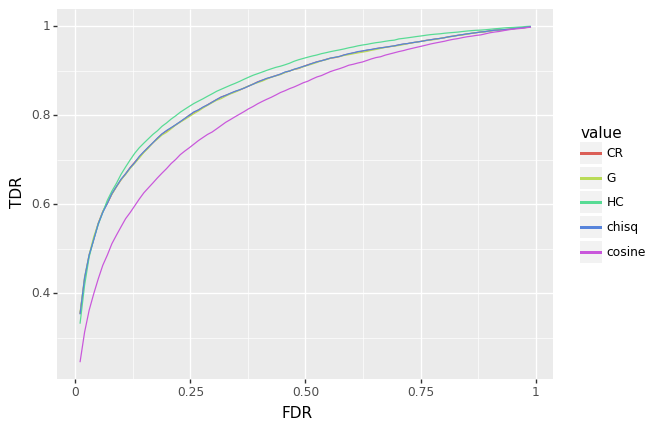

<ggplot: (348229786)>

In [101]:
import numpy as np
import sklearn

qq = np.linspace(0.01,0.99,100)

list_of_colors = ['r', 'b','orange','gray','c']
df = pd.DataFrame()
for i,value in enumerate(['HC', 'chisq', 'G', 'cosine', 'CR']) :
    values = []
    for q in qq :
        FDR = q
        thr = df_res[df_res.same == False][value].quantile(q)
        TDR = [np.mean(df_res[df_res.same == True][value] < thr)]
        df = df.append({ 'value' : value, 'FDR' : q, 'TDR' : TDR[0], 'thr' : thr}, ignore_index=True
                      )
    print(f"AUC of {value} is {sklearn.metrics.roc_auc_score(1-df_res.same, df_res[value])}")
    p = ggplot(aes(x = 'FDR', y='TDR', color='value'), data = df) + geom_line()
p

# Evaluation

In [ ]:
ground_truth_file = "~/Data/PAN/pan20-authorship-verification-training-small/truth.jsonl"
dft = pd.read_json(ground_truth_file, lines=True)
predictions = pd.read_json("./predictions.jsonl", lines=True)
df_all = dft.merge(predictions, on = 'id', how = 'left').dropna()

In [56]:
"blue/green/red_count_30.pkl".split('.pkl')

['blue/green/red_count_30', '']